# Exercise 2

Authors: Joeseph Weibel, Rebecka Fahrni

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter, periodogram, lfilter

## 1. Loading multivariate time-domain data

### 1a Importing data 

In [13]:
data = np.load('data/sample_audvis_raw.npy')
events = np.load('data/events.npy')

# print(events)

n_channels, n_time_samples = data.shape # tuple containing number of leads and time points
n_events = len(events)

print(f'Number of time samples: {n_time_samples}, number of channels: {n_channels}, number of events: {n_events}')


Number of time samples: 166800, number of channels: 305, number of events: 320


## 2. Filtering raw data

#### 2a Implementing a notch filter and high- and low pass filters between 1 and 20 Hz


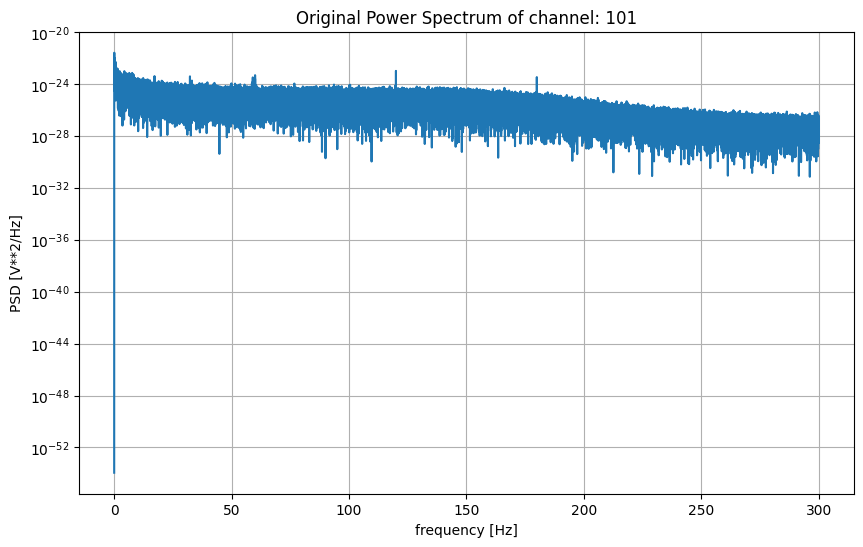

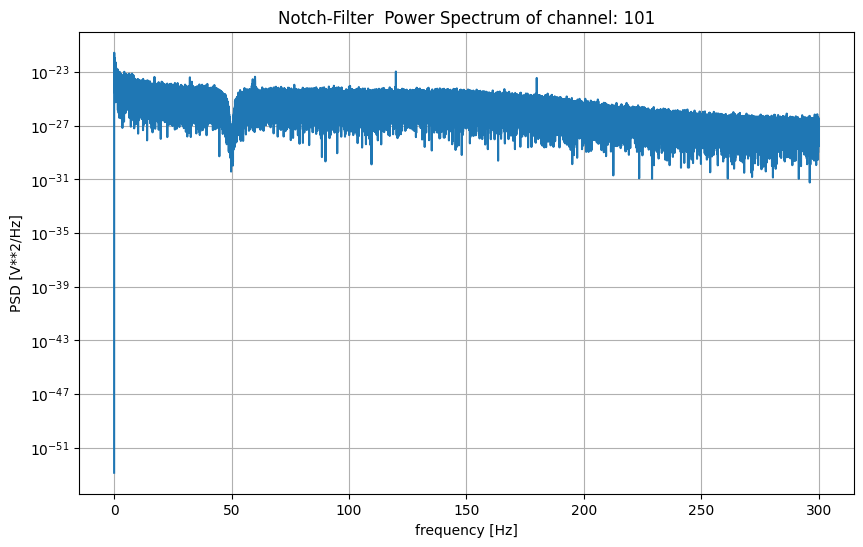

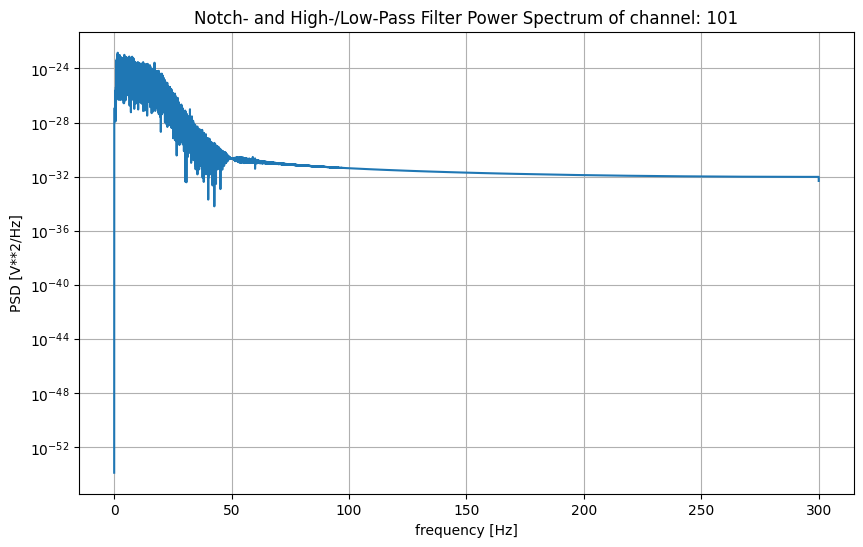

In [29]:

# Notch filter parameters
fs = 600  # sample frequency (Hz)
f0 = 50.0  # frequency to be removed from signal (Hz): notch freq. 
quality_factor = 10 #  a higher quality factor = narrower filter/bandwidth, more precisely targeting the notch freq. (bandwidth = notch_freq / quality_factor)
# design notch filter
b, a = iirnotch(f0, quality_factor, fs)
# apply notch filter
notch_filtered_data = filtfilt(b, a, data)

# High-pass and low-pass filter parameters
lowcut = 1.0
highcut = 20.0

b, a = b, a = butter(4, [lowcut, highcut], fs=fs, btype='bandpass')
notch_high_low_filtered_data = filtfilt(b, a, notch_filtered_data)


# sample channel to test filters
channel_idx = 100

def plot_power_spectrum(d, fs, title):
    f, Pxx_den = periodogram(d, fs)
    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx_den)
    # plt.title(f'Notch-Filter Channel {channel_idx + 1}')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(title)
    plt.grid(True) # or plt.show()

# original data PS of channel 101 
plot_power_spectrum(data[channel_idx], fs, f'Original Power Spectrum of channel: {channel_idx + 1}')

# notch filtered data PS of channel 101 
plot_power_spectrum(notch_filtered_data[channel_idx], fs, f'Notch-Filter  Power Spectrum of channel: {channel_idx + 1}')

# notch and high/low filtered data PS of channel 101
plot_power_spectrum(notch_high_low_filtered_data[channel_idx], fs, f'Notch- and High-/Low-Pass Filter Power Spectrum of channel: {channel_idx + 1}')



#### 2b Describing the effects of filtering

The 3 plots show the power spectral density (PSD) of channel 101 at three different stages of filtering:

- Original Power Spectrum:
  In the unfiltered data there is a significant amount of noise present, with signals recorded across various frequency ranges. Also observe the braodband distribution of power across the frequency spectrum has also a natural decline in higher frequencies. 
 
- Notch Filtered Power Spectrum:
  The second plot displays the PSD after applying a notch filter. This filter specifically targets the removal of power line noise at 50 Hz, we see a noticibale dip in the periodogram at 50 Hz. The notch filter has effectively removed the 50 Hz noise from the data. We see that the dip is not that clear/strong this is due to the selected channel (data) the noise was probably not very strong in the first place.

 
- Notch and high/lowpass-filtered Power Spectrum
  Following the application of the high- and low-pass filters, predominantly only frequencies within this range remain. The farther these frequencies are from 1 and 20 Hz, the less prominently they appear in the filtered data. High frequencies are now missing at all.This indicates the filter effectively isolated the frequency band of interest.

The application of both filters allows for noise suppression. The notch filter removes the 50 Hz noise, while the high- and low-pass filters remove the remaining noise outside the desired frequency range.

## 3 Epoching the data

### 3a Extracting epochs 

In [30]:
# 100 ms before to 500 ms after event
epochs = np.zeros((n_events, n_channels, 100+500+1)) 

for i, event_time in enumerate(events):
    start_index = int(event_time) - 100
    end_index = int(event_time) + 500 + 1
    epochs[i, :, :] = data[:, start_index:end_index]

print(epochs.shape)

(320, 305, 601)


### 3b Plotting average epochs

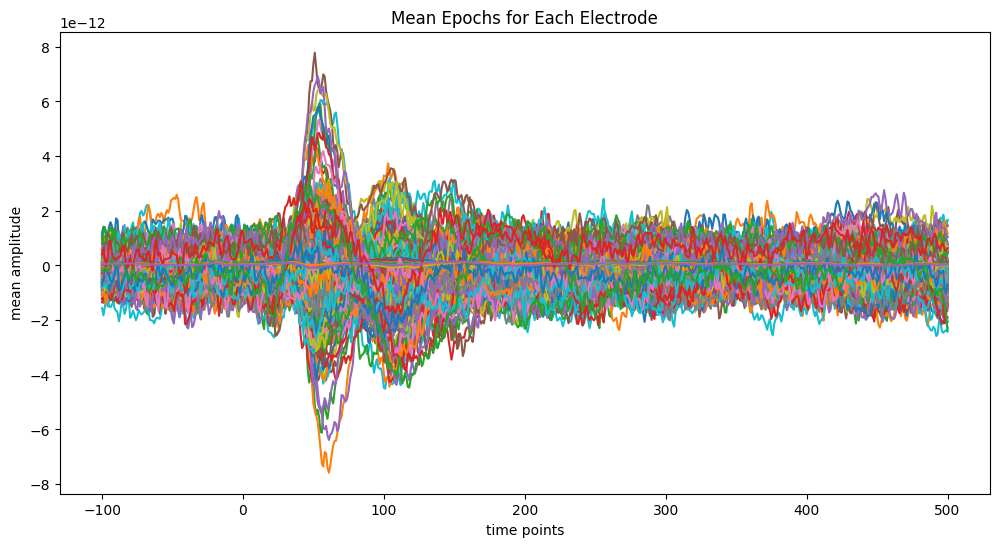

In [33]:
# plot mean epochs for each electrode
mean_epochs = np.mean(epochs, axis=0)

n_electrodes = mean_epochs.shape[0]

plt.figure(figsize=(12, 6))
for electrode in range(n_electrodes):
    plt.plot(np.arange(-100, 501, 1), mean_epochs[electrode, :], label=f'Electrode {electrode + 1}')

plt.title('Mean Epochs for Each Electrode')
plt.xlabel('time points')
plt.ylabel('mean amplitude')
plt.show()


### 3c Filtering and extracting epochs

In [34]:
# epochs based on filtered raw signal 
epochs = np.zeros((n_events, n_channels, 100+500+1))
for i, event_time in enumerate(events):
    start_index = int(event_time) - 100
    end_index = int(event_time) + 500 + 1
    epochs[i, :, :] = notch_high_low_filtered_data[:, start_index:end_index]

print(epochs.shape)


(320, 305, 601)


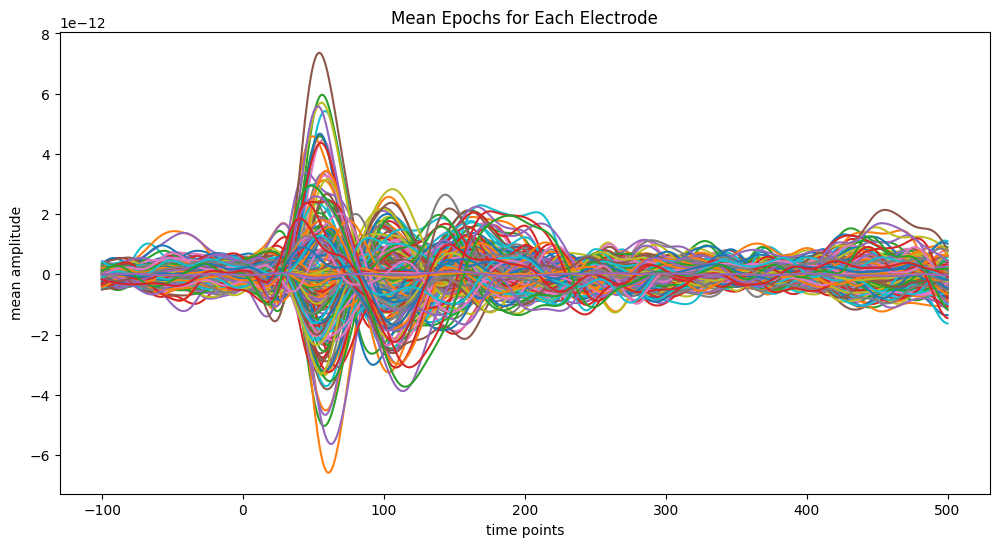

In [35]:
# filtered mean epochs for each electrode
mean_epochs = np.mean(epochs, axis=0)
n_electrodes = mean_epochs.shape[0]

plt.figure(figsize=(12, 6))
for electrode in range(n_electrodes):
    plt.plot(np.arange(-100, 501, 1), mean_epochs[electrode, :], label=f'Electrode {electrode + 1}')

plt.title('Mean Epochs for Each Electrode')
plt.xlabel('time points')
plt.ylabel('mean amplitude')
plt.show()

### 3d Describing the effects of filtering on epochs

Plots illustrate the mean epochs for each electrode before and after applying the filters.

- Before filtering 
    The first plot represents the average across epochs for each channel of the original, unfiltered data. The traces for different channels (each in a different color) show varying degrees of fluctuation before the event (time point zero), and a significant peak shortly after the event. The traces are very jittery, and the peaks are not very clear. This is due to the presence of noise in the data.

- After filtering
    The second plot shows the average across epochs for each channel after the data has been filtered.
    The second plot shows the average across epochs for each channel after applying the filters (notch and bandpass). The traces appear smoother, particularly before the event, indicating that the filters have effectively reduced the noise. The peaks are now more clearly discernible, and the traces are less jittery. Additionally, further peaks following the initial one are now visible, exhibiting a lower amplitude than the first peak. It is now also easier to discern that, during the baseline period, most electrodes did not record any anomalies.

The application of the filters has effectively reduced the noise in the data, making it easier to discern the event-related potentials (ERPs) in the data.
